# State Fidelity via Swap Test

The purpose of this notebook is to test the functionality of a simple swap circuit which can be theoretically used to return the fidelity of two quantum states, as proposed by [Basheer, Afham and Goyal](https://arxiv.org/pdf/2003.09187) in 2021. While packages such as IBM's Qiskit include functions for returning the fidelity of two states, these calculations are performed classically. Since QNLP utilises a quantum pipeline, it makes sense to include fidelity calculations as part of this pipeline rather than as a classical step after it.

In [73]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_multivector
import numpy as np

The circuit consist of two quantum registers; a *state register* containing two qubits which are supposed to be in the states to be compared, and a *control register* containing one qubit which is measured to determine the fidelity. There is also a classical register in which the results of the measurement are stored. The swap_test 

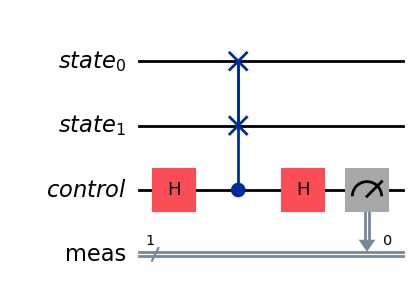

In [107]:
# Setting up registers
state_reg = QuantumRegister(2, 'state')
control_reg = QuantumRegister(1, 'control')
meas_reg = ClassicalRegister(1, "meas")
qc = QuantumCircuit(state_reg, control_reg, meas_reg)

# Fidelity measurement circuit
def add_swap_test(qc):
    qc.h(control_reg)
    qc.cswap(control_reg, *state_reg)
    qc.h(control_reg)
    qc.measure(control_reg, meas_reg)
    display(qc.draw('mpl'))
    return qc

qc = add_swap_test(qc)

Note: I have added a function to add the swap test to the circuit, as this allows me to initialize the state qubits before performing the swap test.

I then write a small function to calculate the fidelity of the two states from the results of the measurement, using the equation derived in the same paper linked above.

In [108]:
def fidelity_calc(results, num_shots):
    counts = results.get_counts()
    fidelity = 1/num_shots * (counts.get('0', 0) - counts.get('1', 0))  # Using equation from paper
    return fidelity

To test the circuit, I initialize both qubits in the state register into the same random state, run the simulation and check that I obtain a fidelity of 1 (rounding to account for noise).

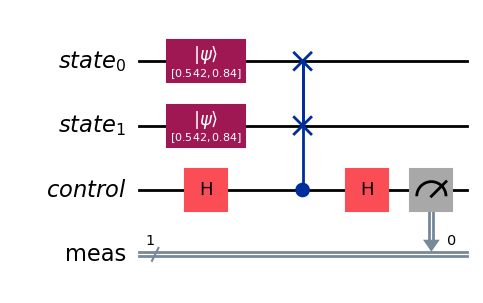

Circuit Working Correctly


In [155]:
# Initialize qubits
random_state = np.random.rand(2)
random_state = random_state/np.linalg.norm(random_state)  # Normalise
qc.clear()  # Clear circuit
qc.initialize(random_state, state_reg[0])
qc.initialize(random_state, state_reg[1])
qc = add_swap_test(qc)  # Add swap test circuit after qubit initialization

# Run the simulation
NUM_SHOTS = 1024
sim = AerSimulator()
job = sim.run(qc, shots=NUM_SHOTS)
results = job.result()

# Calculate + Verify Fidelity
fidelity = fidelity_calc(results, NUM_SHOTS)
assert(np.round(fidelity, 3)==1)
print('Circuit Working Correctly')


I can now initialize the qubits in the state register into two random orthogonal states and check that I obtain a fidelity of 0.

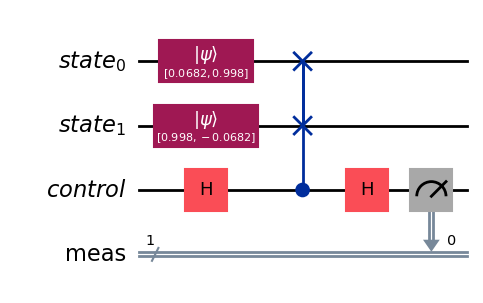

Circuit Working Correctly


In [163]:
# Initialize qubits
random_state_1 = np.random.rand(2)
random_state_1 = random_state_1/np.linalg.norm(random_state_1)
random_state_2 = np.random.rand(2)
random_state_2 -= (random_state_1 @ random_state_2) * random_state_1  # Gram-Schmidt Process
random_state_2 = random_state_2/np.linalg.norm(random_state_2)

qc.clear()
qc.initialize(random_state_1, state_reg[0])
qc.initialize(random_state_2, state_reg[1])
qc = add_swap_test(qc)

# Run the simulation
job = sim.run(qc, shots=2**15)
results = job.result()

# Calculate + Print Fidelity
fidelity = fidelity_calc(results, 2**15)
print(f'Fidelity: {fidelity}')
